In [0]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# Load dataset from Databricks workspace table
df = spark.sql("SELECT * FROM workspace.default.synthetic_atm_cash_data").toPandas()

# Display top rows
print(" Dataset Loaded Successfully. Shape:", df.shape)
display(df.head())


 Dataset Loaded Successfully. Shape: (1825, 8)


Date,ATM_ID,Location,Withdrawals,Deposits,DayOfWeek,IsHoliday,WeatherImpact
2023-01-01,ATM_1,Urban,7191,10734,6,1,2
2023-01-01,ATM_2,Urban,12578,13322,6,1,0
2023-01-01,ATM_3,Urban,8949,7433,6,1,2
2023-01-01,ATM_4,Urban,11555,8385,6,1,0
2023-01-01,ATM_5,Urban,15666,14274,6,1,0


In [0]:
# Data Wrangling
# Importing libraries and dataset
# Check data types and summary
print("\nData Information:")
print(df.info())

print("\nMissing Values per Column:")
print(df.isnull().sum())

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

#  Convert numeric fields properly
df['Withdrawals'] = pd.to_numeric(df['Withdrawals'], errors='coerce')

#  Handle Missing Values
df['Withdrawals'].fillna(df['Withdrawals'].median(), inplace=True)
df['Location'].fillna(df['Location'].mode()[0], inplace=True)
df['IsHoliday'].fillna("No", inplace=True)
df['WeatherImpact'].fillna("Normal", inplace=True)

#  Remove Duplicates
df.drop_duplicates(inplace=True)

#  Sort by Date for time series consistency
df = df.sort_values(by='Date').reset_index(drop=True)




Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                1825 non-null   object 
 1   ATM_ID              1825 non-null   object 
 2   Location            1825 non-null   object 
 3   Withdrawals         1825 non-null   int64  
 4   Deposits            1825 non-null   int64  
 5   DayOfWeek           1825 non-null   object 
 6   IsHoliday           1825 non-null   int64  
 7   WeatherImpact       1825 non-null   int64  
 8   Month               1825 non-null   int32  
 9   Day                 1825 non-null   int32  
 10  WeekOfYear          1825 non-null   int64  
 11  PrevDayWithdrawals  1825 non-null   float64
 12  RollingMean_3       1825 non-null   float64
dtypes: float64(2), int32(2), int64(5), object(4)
memory usage: 171.2+ KB
None

Missing Values per Column:
Date                  0
ATM_ID  

/home/spark-b7d001b5-f5d8-4e03-8b61-f4/.ipykernel/2478/command-6212089310695744-3070909069:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Withdrawals'].fillna(df['Withdrawals'].median(), inplace=True)
/home/spark-b7d001b5-f5d8-4e03-8b61-f4/.ipykernel/2478/command-6212089310695744-3070909069:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediat

In [0]:

# Ensure all dates are valid datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows with completely invalid dates if any
df = df.dropna(subset=['Date'])

# Optional: convert back to string for Spark compatibility
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

print("✅ Date column cleaned and standardized.")


✅ Date column cleaned and standardized.


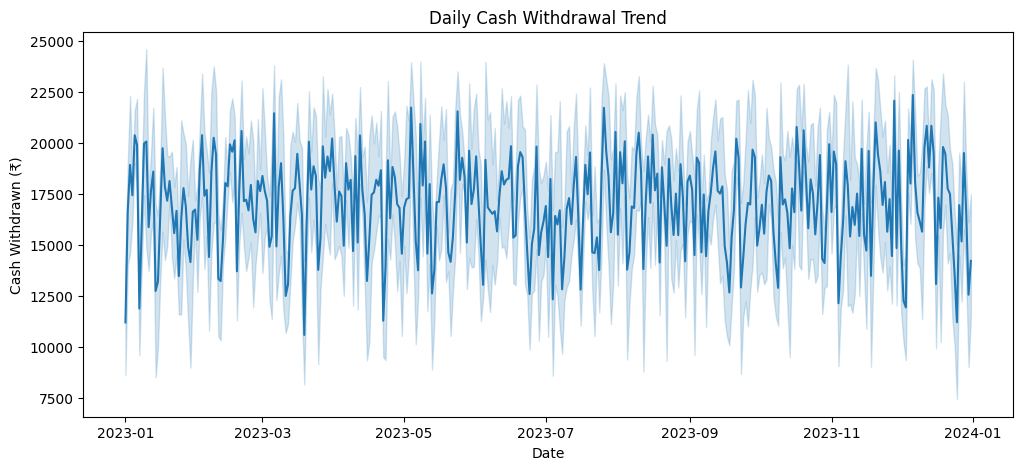

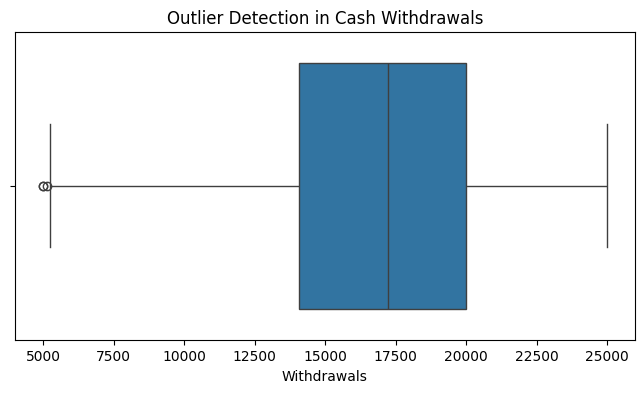

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Date back to datetime for visualization
df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(12,5))
sns.lineplot(x='Date', y='Withdrawals', data=df)
plt.title("Daily Cash Withdrawal Trend")
plt.xlabel("Date")
plt.ylabel("Cash Withdrawn (₹)")
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x=df['Withdrawals'])
plt.title("Outlier Detection in Cash Withdrawals")
plt.show()


In [0]:
# Data preprocessing
# Standardize column names
df.columns = df.columns.str.strip().str.replace(" ", "_")

# Ensure columns exist and are strings before applying string functions
# Convert IsHoliday and WeatherImpact safely to string
df['IsHoliday'] = df['IsHoliday'].astype(str).str.capitalize()
df['WeatherImpact'] = df['WeatherImpact'].astype(str).str.capitalize()

# Replace unexpected values with defaults
valid_holiday_values = ['Yes', 'No']
valid_weather_values = ['Normal', 'Moderate', 'High']

df['IsHoliday'] = df['IsHoliday'].apply(lambda x: x if x in valid_holiday_values else 'No')
df['WeatherImpact'] = df['WeatherImpact'].apply(lambda x: x if x in valid_weather_values else 'Normal')

# Remove invalid or negative cash withdrawals
df = df[df['Withdrawals'] >= 0]

# Confirm date range
print("Date range in data:", df['Date'].min(), "to", df['Date'].max())

# Encode categorical variables for modeling
df['IsHoliday'] = df['IsHoliday'].map({'Yes': 1, 'No': 0})
df['WeatherImpact'] = df['WeatherImpact'].map({'Normal': 0, 'Moderate': 1, 'High': 2})

print("\n Data Preprocessing Completed Successfully!")
display(df.head())


Date range in data: 2023-01-01 to 2023-12-31

 Data Preprocessing Completed Successfully!


Date,ATM_ID,Location,Withdrawals,Deposits,DayOfWeek,IsHoliday,WeatherImpact
2023-01-01,ATM_1,Urban,7191,10734,6,0,0
2023-01-01,ATM_2,Urban,12578,13322,6,0,0
2023-01-01,ATM_3,Urban,8949,7433,6,0,0
2023-01-01,ATM_4,Urban,11555,8385,6,0,0
2023-01-01,ATM_5,Urban,15666,14274,6,0,0


In [0]:
# ==============================================================
# Feature Engineering (Fixed)
# ==============================================================

print("\n🧩 Creating New Features...")

# Ensure Date column is in datetime format before using .dt
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop any rows where Date is invalid (just in case)
df = df.dropna(subset=['Date'])

# Extract temporal features
df['DayOfWeek'] = df['Date'].dt.day_name()
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

# Lag feature — previous day's cash withdrawal per ATM
df = df.sort_values(['ATM_ID', 'Date'])
df['PrevDayWithdrawals'] = df.groupby('ATM_ID')['Withdrawals'].shift(1)

# Rolling mean of last 3 days
df['RollingMean_3'] = df.groupby('ATM_ID')['Withdrawals'].transform(lambda x: x.rolling(3).mean())

# Replace NaNs created by shift or rolling mean
df.fillna(0, inplace=True)

print("\n✅ Feature Engineering Completed Successfully!")
display(df.head())



🧩 Creating New Features...

✅ Feature Engineering Completed Successfully!


Date,ATM_ID,Location,Withdrawals,Deposits,DayOfWeek,IsHoliday,WeatherImpact,Month,Day,WeekOfYear,PrevDayWithdrawals,RollingMean_3
2023-01-01T00:00:00.000Z,ATM_1,Urban,7191,10734,Sunday,0,0,1,1,52,0.0,0.0
2023-01-02T00:00:00.000Z,ATM_1,Urban,17747,14167,Monday,0,0,1,2,1,7191.0,0.0
2023-01-03T00:00:00.000Z,ATM_1,Urban,22099,14670,Tuesday,0,0,1,3,1,17747.0,15679.0
2023-01-04T00:00:00.000Z,ATM_1,Rural,17629,6798,Wednesday,0,0,1,4,1,22099.0,19158.333333333332
2023-01-05T00:00:00.000Z,ATM_1,Rural,19687,8258,Thursday,0,0,1,5,1,17629.0,19805.0


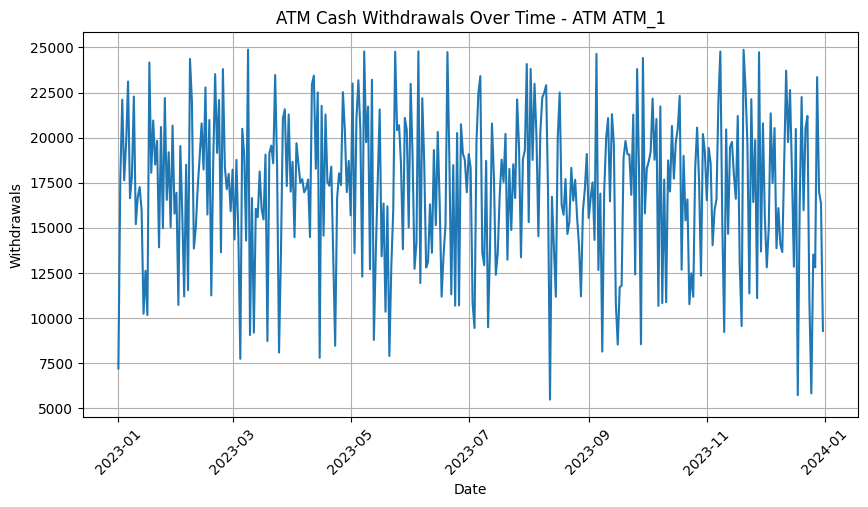

In [0]:
# Time series trend for one sample ATM
sample_atm = df['ATM_ID'].unique()[0]
sample_data = df[df['ATM_ID'] == sample_atm]

plt.figure(figsize=(10,5))
plt.plot(sample_data['Date'], sample_data['Withdrawals'])
plt.title(f"ATM Cash Withdrawals Over Time - ATM {sample_atm}")
plt.xlabel("Date")
plt.ylabel("Withdrawals")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

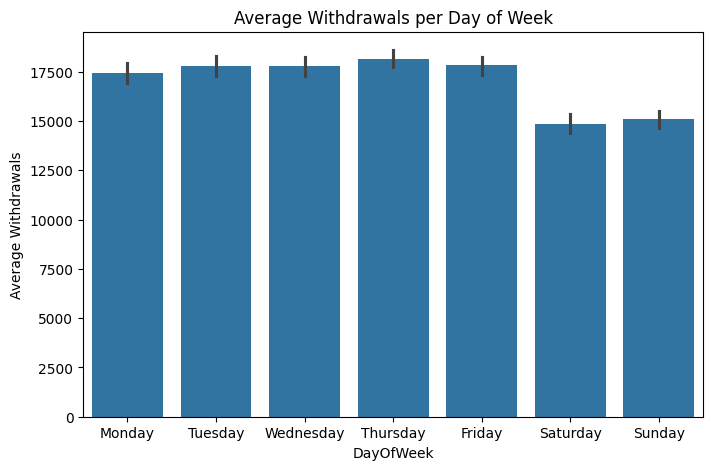

In [0]:
# Average cash withdrawn per day of week
plt.figure(figsize=(8,5))
sns.barplot(x='DayOfWeek', y='Withdrawals', data=df, estimator=np.mean, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title("Average Withdrawals per Day of Week")
plt.ylabel("Average Withdrawals")
plt.show()

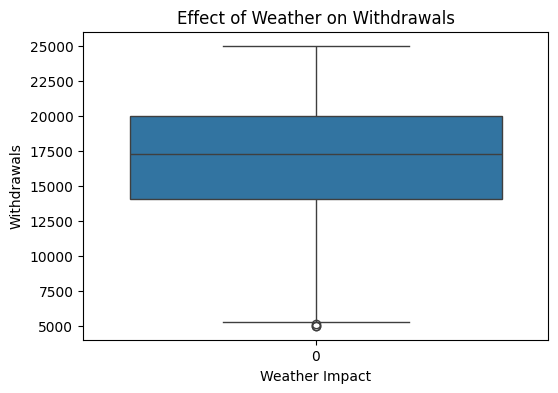

In [0]:
# Effect of weather on withdrawals
plt.figure(figsize=(6,4))
sns.boxplot(x='WeatherImpact', y='Withdrawals', data=df)
plt.title("Effect of Weather on Withdrawals")
plt.xlabel("Weather Impact")
plt.ylabel("Withdrawals")
plt.show()

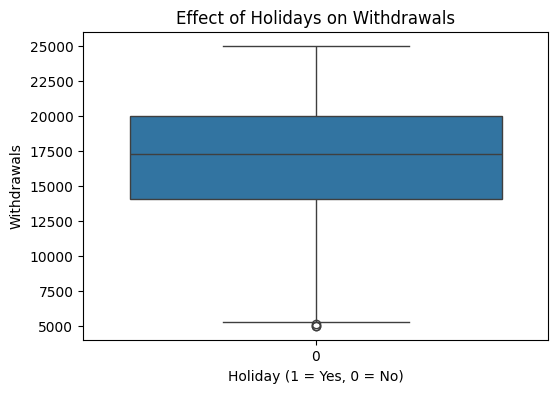

In [0]:
# Effect of holidays on withdrawals
plt.figure(figsize=(6,4))
sns.boxplot(x='IsHoliday', y='Withdrawals', data=df)
plt.title("Effect of Holidays on Withdrawals")
plt.xlabel("Holiday (1 = Yes, 0 = No)")
plt.ylabel("Withdrawals")
plt.show()

/home/spark-b7d001b5-f5d8-4e03-8b61-f4/.ipykernel/2478/command-6212089310695759-1605344166:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_atms, x='ATM_ID', y='Withdrawals', palette='coolwarm')


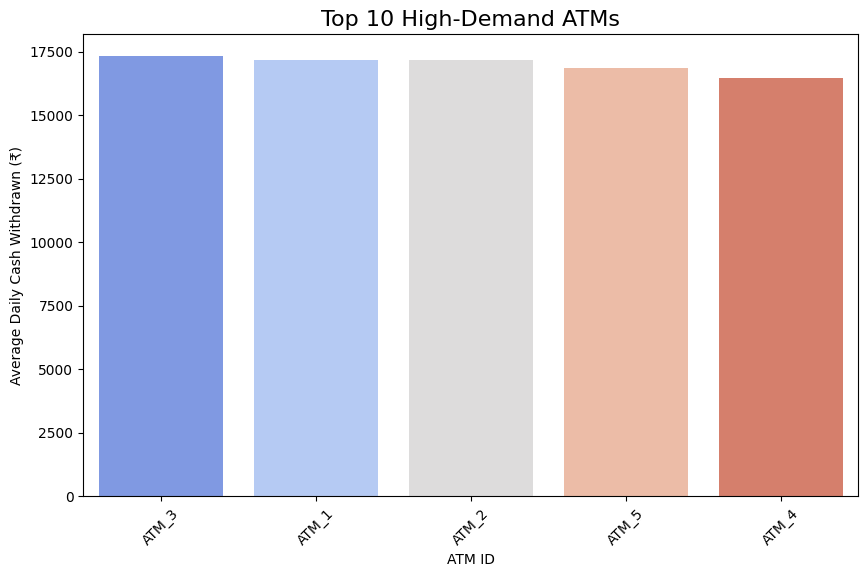

In [0]:
top_atms = df.groupby('ATM_ID')['Withdrawals'].mean().nlargest(10).reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=top_atms, x='ATM_ID', y='Withdrawals', palette='coolwarm')
plt.title("Top 10 High-Demand ATMs", fontsize=16)
plt.xlabel("ATM ID")
plt.ylabel("Average Daily Cash Withdrawn (₹)")
plt.xticks(rotation=45)
plt.show()

/home/spark-b7d001b5-f5d8-4e03-8b61-f4/.ipykernel/2478/command-6212089310695760-1452614305:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=weekly_pattern, x='DayOfWeek', y='Withdrawals', palette='viridis')


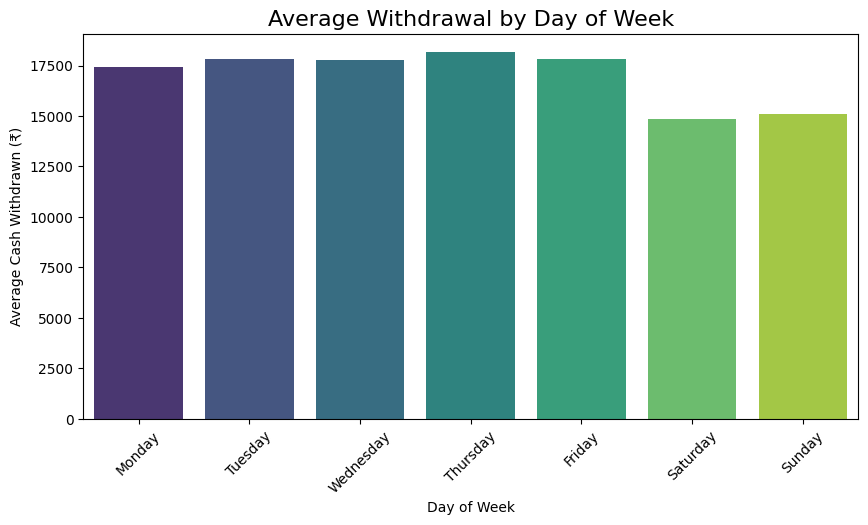

In [0]:
df['DayOfWeek'] = df['Date'].dt.day_name()

weekly_pattern = df.groupby('DayOfWeek')['Withdrawals'].mean().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']).reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=weekly_pattern, x='DayOfWeek', y='Withdrawals', palette='viridis')
plt.title("Average Withdrawal by Day of Week", fontsize=16)
plt.xlabel("Day of Week")
plt.ylabel("Average Cash Withdrawn (₹)")
plt.xticks(rotation=45)
plt.show()

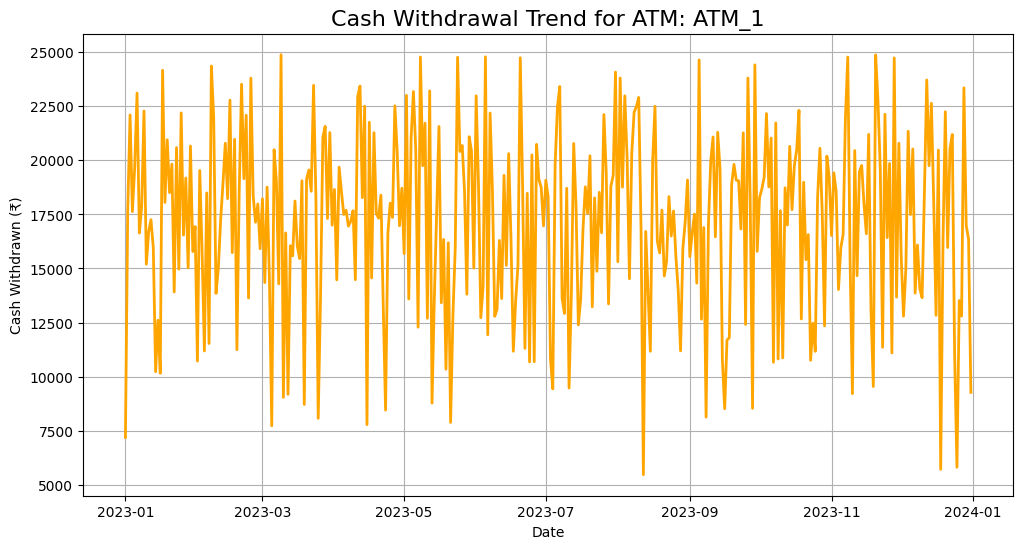

In [0]:
# Select one ATM ID for visualization
sample_atm = df['ATM_ID'].unique()[0]
atm_trend = df[df['ATM_ID'] == sample_atm].groupby('Date')['Withdrawals'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=atm_trend, x='Date', y='Withdrawals', color='orange', linewidth=2)
plt.title(f"Cash Withdrawal Trend for ATM: {sample_atm}", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Cash Withdrawn (₹)")
plt.grid(True)
plt.show()

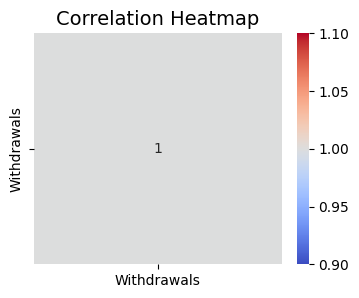

In [0]:
# Select only numerical columns
num_cols = ['Withdrawals']
corr = df[num_cols].corr()

plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap", fontsize=14)
plt.show()